# Cross Validation of Naive Bayes Document Classification

 We use cross validation to select between `Set`, `Count` or `Tf-Id` bag or word text representations on a naive bayes classifier.

We will use again the Reuters `C50` text corpus for our analysis. 


## Preliminaries

### Imports

In [1]:
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import KFold 

import sys
sys.path.append("../..")
from E4525_ML import plots

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

### Random Seed

In [2]:
seed=3565
np.random.seed(seed)

### Data Directories

In [3]:
raw_data_dir=r"../../raw/C50/C50train"
test_dir    =r"../../raw/C50/C50test"
data_dir=r"../../data/C50"


## Document Data

### Corpus (List of documents)

In [4]:
documents_filename=data_dir+"/C50_documents.csv"
documents=pd.read_csv(documents_filename,index_col="document_id")
documents.head()

,filename,label
document_id,,
0,../../raw/C50/C50train/ScottHillis/253868newsM...,ScottHillis
1,../../raw/C50/C50train/ScottHillis/305692newsM...,ScottHillis
2,../../raw/C50/C50train/ScottHillis/340736newsM...,ScottHillis
3,../../raw/C50/C50train/ScottHillis/140340newsM...,ScottHillis
4,../../raw/C50/C50train/ScottHillis/126593newsM...,ScottHillis


In [5]:
test_documents_filename=data_dir+"/C50_test_documents.csv"
test_documents=pd.read_csv(test_documents_filename,index_col="document_id")
test_documents.head()

,filename,label
document_id,,
0,../../raw/C50/C50test/ScottHillis/373999newsML...,ScottHillis
1,../../raw/C50/C50test/ScottHillis/348602newsML...,ScottHillis
2,../../raw/C50/C50test/ScottHillis/387913newsML...,ScottHillis
3,../../raw/C50/C50test/ScottHillis/392527newsML...,ScottHillis
4,../../raw/C50/C50test/ScottHillis/417664newsML...,ScottHillis


### Load Pre-Trained Features

#### Set Features

In [6]:
set_features_filename=data_dir+"/"+"set_features.p"
set_features=pickle.load(open(set_features_filename,"rb"))

In [7]:
set_test_features_filename=data_dir+"/"+"set_test_features.p"
set_test_features=pickle.load(open(set_test_features_filename,"rb"))

#### Count Features

In [8]:
count_features_filename=data_dir+"/"+"count_features.p"
count_features=pickle.load(open(count_features_filename,"rb"))

In [9]:
count_test_features_filename=data_dir+"/"+"count_test_features.p"
count_test_features=pickle.load(open(count_test_features_filename,"rb"))

#### TF-IDF Features

In [10]:
tfidf_features_filename=data_dir+"/"+"tfidf_features.p"
tfidf_features=pickle.load(open(tfidf_features_filename,"rb"))

In [11]:
tfidf_test_features_filename=data_dir+"/"+"tfidf_test_features.p"
tfidf_test_features=pickle.load(open(tfidf_test_features_filename,"rb"))

### Scramble train and test data

In [12]:
scramble=False

In [13]:
if scramble:
    all_docs=pd.concat([documents,test_documents])
    print("all_docs.shape",all_docs.shape)
    msk=np.random.rand(len(all_docs))<0.5
    documents=all_docs[msk]
    test_documents=all_docs[~msk]
    print(documents.shape,test_documents.shape)

In [14]:
import scipy.sparse

In [15]:
def scramble_features(X,X_test,msk):
    X_all=scipy.sparse.vstack([X,X_test])
    return X_all[msk],X_all[~msk]

In [16]:
if scramble:
    count_features,count_test_features=scramble_features(count_features,count_test_features,msk)
    print(count_features.shape,count_test_features.shape)
    tfidf_features,tfidf_test_features=scramble_features(tfidf_features,tfidf_test_features,msk)
    print(tfidf_features.shape,tfidf_test_features.shape)
    set_features,set_test_features=scramble_features(set_features,set_test_features,msk)
    print(set_features.shape,set_test_features.shape)


## Naive-Bayes Classifier

In [17]:
class NaiveBayes:
    def __init__(self,alpha):
        self.alpha=alpha
        
    def fit(self,X,Y):
        V=X.shape[1]
        dummies=pd.get_dummies(Y,prefix="",prefix_sep="",sparse=True)
        self.classes=dummies.columns
        Z=dummies.to_coo()
        word_counts=Z.T.dot(X).todense()
        class_word_counts=word_counts.sum(axis=1)
        self.b=np.log(Z.sum(axis=0)/Z.sum())
        self.w=np.log((self.alpha+word_counts)/(self.alpha*V+class_word_counts))
    def predict(self,X):
        L=self.b+X.dot(self.w.T)
        Y_pred=L.argmax(axis=1)
        return np.array(self.classes[Y_pred]).ravel()

In [18]:
alpha=1

In [19]:
model=NaiveBayes(alpha)

In [20]:
Y=documents["label"].as_matrix()
Y_test=test_documents["label"].as_matrix()

In [21]:
N=count_features.shape[0]
V=count_features.shape[1] # Vocabulary size
print("alpha = ",alpha)
print("N     = ",N)
print("V     = ",V)

alpha =  1
N     =  2500
V     =  28060


## Cross Validation

In [22]:
def model_cross_validation(model,X,y,folds):
    kfolds=len(folds)
    train_performance=np.empty(kfolds)
    validation_performance=np.empty(kfolds)
    for idx in range(kfolds):
        train,validation=folds[idx]
        X_train=X[train]
        y_train=y[train]
        model.fit(X_train,y_train)
        train_accuracy=np.average(model.predict(X_train)==y_train)
        X_validation=X[validation]
        y_validation=y[validation]
        validation_accuracy=np.average(model.predict(X_validation)==y_validation)
        train_performance[idx]=train_accuracy
        validation_performance[idx]=validation_accuracy
    return np.array(train_performance),np.array(validation_performance)

In [23]:
K=10

In [24]:
kf=KFold(10,shuffle=True)
folds=list(kf.split(set_features))

In [25]:
t,v_count=model_cross_validation(model,count_features,Y,folds)
print(t.mean(),v_count.mean())

0.9681777777777778 0.7968


In [26]:
t,v_tfidf=model_cross_validation(model,tfidf_features,Y,folds)
print(t.mean(),v_tfidf.mean())

0.9183555555555556 0.7347999999999999


In [27]:
t,v_set=model_cross_validation(model,set_features,Y,folds)
print(t.mean(),v_set.mean())

0.9850222222222221 0.798


In [28]:
# we save in a panda's data frame to make a pretty graph later
datav=np.vstack((v_count,v_tfidf,v_set)).T
data=pd.DataFrame(datav,columns=["Count","TfIdf","Set"])

## Fit best model to all training data and test

In [29]:
model.fit(count_features,Y)
Y_pred=model.predict(count_test_features)
accuracy=np.mean(Y_pred==Y_test)
accuracy

0.65

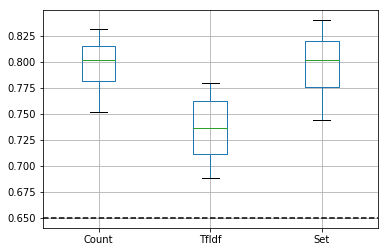

In [30]:
ax=data.boxplot()
ax.axhline(y=accuracy,linestyle="dashed",color="k")